**Objective**: To expose the best combination for strategy games available in the appstore in order to get a good user rating (4.0/5.0 and above)
To analyse the dataset, we will look at the relationship as below:

**Strategy**
* Genre grouping
* Game Size analysis
* Release date/ Update date factor
* Game Price and In-App Purchase Factor (Grouped by Genre)
* Age Rating Factor 

**Data Cleaning**
* Games without User Rating are dropped.
* Games with less than 200 user rating AND days since last update date <6month are dropped to prevent biased ratings from the developer
* Genre tags "Entertainment" and "Games" are removed from the Genre string as it does not provide meaningful insight
* The remaining of the string are checked and grouped as follows:
     1. Puzzle= Puzzle/Board
     2. Adventure= Adventure/Role/Role Playing
     3. Action = Action
     4. Family = Family/Education


In [1]:
import pandas as pd
gamestats = pd.read_csv('/kaggle/input/17k-apple-app-store-strategy-games/appstore_games.csv')
gamestatsf=gamestats.copy()
# Drop unused rows and columns
gamestatsf = gamestatsf.drop(columns="URL")
gamestatsf = gamestatsf.drop(columns="Icon URL")

gamestatsf.columns= ['ID', 'Name','Subtitle','User_Rating','User_Rating_Count','Price','In_App_Purchase','Desc','Dev','Age_Rating','Languages','Size','Primary_Genre','Genre','Release_Date','Current_Version_Date']
#Drop games that has no rating
gamestatsf = gamestatsf[pd.notnull(gamestatsf['User_Rating'])]
# Converting Date strings to datetime objects
import datetime

gamestatsf['Release_Date'] = pd.to_datetime(gamestatsf['Release_Date'])
gamestatsf['Current_Version_Date'] = pd.to_datetime(gamestatsf['Current_Version_Date'])
#New column for time gap between release & update
gamestatsf['Update_Gap']=gamestatsf.Current_Version_Date-gamestatsf.Release_Date
# To prevent biased ratings,Drop games that has rating less than 200 user rating count AND 
#(Release Date to Update date) less than 6 months

Low_User_Count=(gamestatsf[gamestatsf.User_Rating_Count < 200].index) &\
gamestatsf[gamestatsf.Update_Gap < datetime.timedelta(days=175)].index

gamestatsf.drop(Low_User_Count , inplace=True)

In [2]:
gamestatsfg = gamestatsf.copy()
gamestatsfg['Genre'] = gamestatsfg['Genre'].str.replace(',', '').str.replace('Games', '').str.replace('Entertainment', '').str.replace('Strategy', '') 
gamestatsfg['Genre'] = gamestatsfg['Genre'].str.split(' ').map(lambda x: ' '.join(sorted(x)))
gamestatsfg['Genre']=gamestatsfg['Genre'].str.strip()
Non_Main_Genre=gamestatsfg[~gamestatsfg.Genre.str.contains('Puzzle') & \
                           ~gamestatsfg.Genre.str.contains('Action') & \
                           ~gamestatsfg.Genre.str.contains('Family')& \
                           ~gamestatsfg.Genre.str.contains('Education')& \
                           ~gamestatsfg.Genre.str.contains('Family')& \
                           ~gamestatsfg.Genre.str.contains('Adventure')&\
                           ~gamestatsfg.Genre.str.contains('Board')&\
                           ~gamestatsfg.Genre.str.contains('Role')].index
gamestatsfg.drop(Non_Main_Genre , inplace=True)
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Puzzle'),'Genre'] = 'Puzzle'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Board'),'Genre'] = 'Puzzle'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Action'),'Genre'] = 'Action'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Adventure'),'Genre'] = 'Adventure'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Role'),'Genre'] = 'Adventure'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Family'),'Genre'] = 'Family'
gamestatsfg.loc[gamestatsfg['Genre'].str.contains('Education'),'Genre'] = 'Family'
    
    



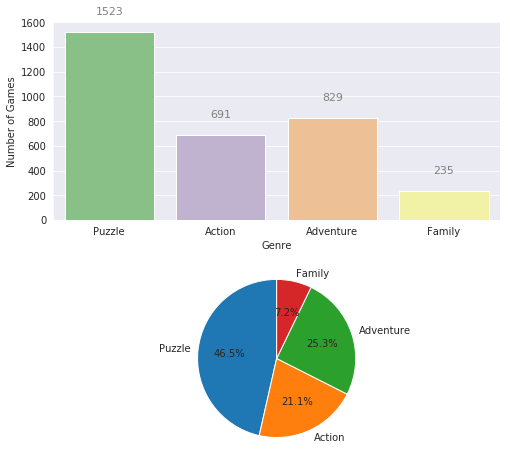

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')
f, axes = plt.subplots (2,1, figsize=(8,8))

#Histogram
x=['Puzzle','Action','Adventure','Family']
y = [gamestatsfg.Genre[(gamestatsfg['Genre']=='Puzzle')].count(),gamestatsfg.Genre[(gamestatsfg['Genre']=='Action')].count(),\
     gamestatsfg.Genre[(gamestatsfg['Genre']=='Adventure')].count(),gamestatsfg.Genre[(gamestatsfg['Genre']=='Family')].count()]

vis1= sns.barplot(x,y,palette='Accent',ax=axes[0])
vis1.set(xlabel='Genre',ylabel='Number of Games')
for p in vis1.patches:
             vis1.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')


#Pie Chart
NG = [gamestatsfg.Genre[(gamestatsfg['Genre']=='Puzzle')].count(),gamestatsfg.Genre[(gamestatsfg['Genre']=='Action')].count(),\
     gamestatsfg.Genre[(gamestatsfg['Genre']=='Adventure')].count(),gamestatsfg.Genre[(gamestatsfg['Genre']=='Family')].count()]
G = ['Puzzle','Action','Adventure','Family']

plt.pie(NG, labels=G, startangle=90, autopct='%.1f%%')
plt.show()


plt.ioff()

Simple Analysis on Genre distribution, we can see that number of games follows Puzzle > Adventure > Action > Family

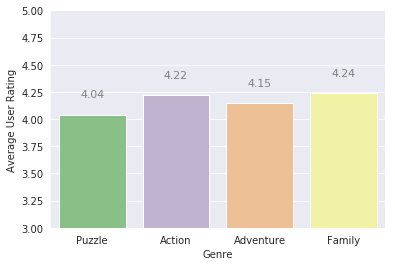

In [4]:
x=['Puzzle','Action','Adventure','Family']
y = [gamestatsfg.User_Rating[(gamestatsfg['Genre']=='Puzzle')].mean(),\
     gamestatsfg.User_Rating[(gamestatsfg['Genre']=='Action')].mean(),\
     gamestatsfg.User_Rating[(gamestatsfg['Genre']=='Adventure')].mean(),\
     gamestatsfg.User_Rating[(gamestatsfg['Genre']=='Family')].mean()]

vis1= sns.barplot(x,y,palette='Accent')
vis1.set(xlabel='Genre',ylabel='Average User Rating')
vis1.set(ylim=(3,5))


for p in vis1.patches:
             vis1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')

plt.ioff()

Average Rating based on Genre shows Action and Family games have slightly higher User Rating compared to Puzzle and Adventure games

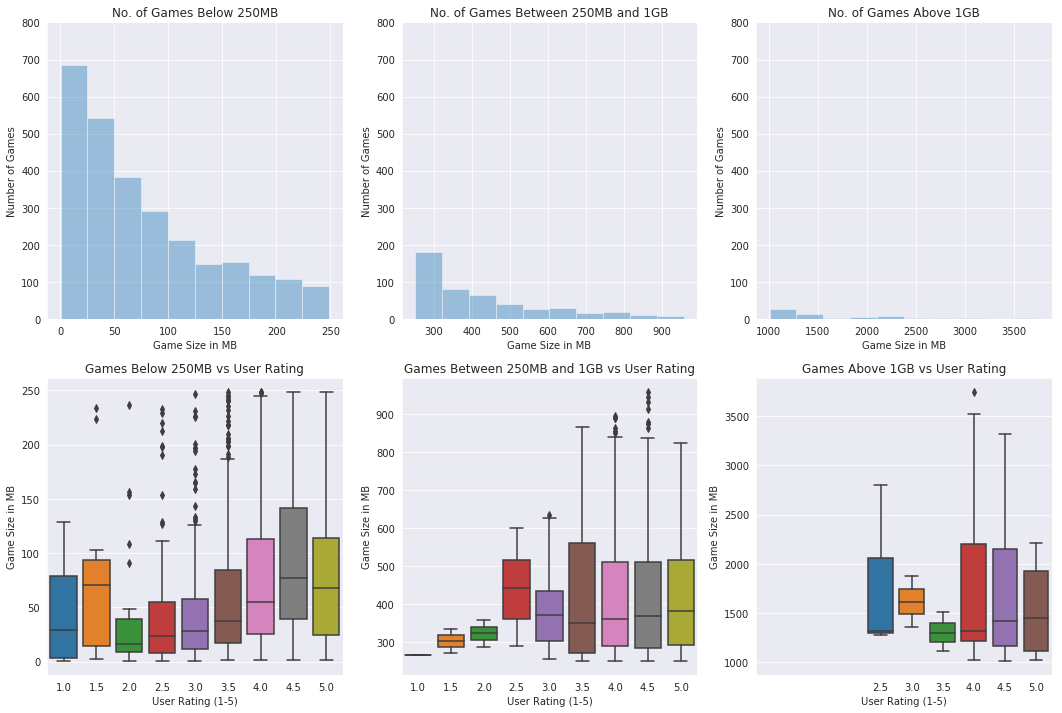

In [5]:
gamestatsfg['Size2'] = round(gamestatsfg['Size']/1000000,1)
Size_Less_250MB = gamestatsfg[gamestatsfg.Size2 <250]
Size_More_250MB = gamestatsfg[(gamestatsfg.Size2 >=250) & (gamestatsfg.Size2 <1000)]
Size_More_1GB = gamestatsfg[gamestatsfg.Size2 >=1000]


sns.set_style('darkgrid')
f, axes = plt.subplots (2,3, figsize=(18,12))



vis1 = sns.boxplot( data = Size_Less_250MB, x = 'User_Rating', y = 'Size2',  ax=axes[1,0])
vis2 = sns.boxplot( data = Size_More_250MB, x = 'User_Rating', y = 'Size2', ax=axes[1,1])
vis3 = sns.boxplot( data = Size_More_1GB, x = 'User_Rating', y = 'Size2', ax=axes[1,2],)
vis4 = sns.distplot(Size_Less_250MB.Size2, bins= 10, kde=False,ax=axes[0,0])
vis5 = sns.distplot(Size_More_250MB.Size2, bins= 10, kde=False,ax=axes[0,1])
vis6 = sns.distplot(Size_More_1GB.Size2, bins= 10, kde=False,ax=axes[0,2])

vis1.set(xlabel='User Rating (1-5)',ylabel='Game Size in MB')
vis2.set(xlabel='User Rating (1-5)',ylabel='Game Size in MB')
vis3.set(xlabel='User Rating (1-5)',ylabel='Game Size in MB')
vis4.set(xlabel='Game Size in MB',ylabel='Number of Games')
vis5.set(xlabel='Game Size in MB',ylabel='Number of Games')
vis6.set(xlabel='Game Size in MB',ylabel='Number of Games')

axes[0, 0].set_title('No. of Games Below 250MB')
axes[0, 1].set_title('No. of Games Between 250MB and 1GB')
axes[0, 2].set_title('No. of Games Above 1GB')
axes[1, 0].set_title('Games Below 250MB vs User Rating')
axes[1, 1].set_title('Games Between 250MB and 1GB vs User Rating')
axes[1, 2].set_title('Games Above 1GB vs User Rating')
vis3.set(xlim=(-4, 5.5))

vis4.set(ylim=(0, 800))
vis5.set(ylim=(0, 800))
vis6.set(ylim=(0, 800))

plt.ioff()

**Size Factor**
* From the visualization, we can see that most of the game are below 250MB In which to achieve score 4 and above it has to be 100MB and above.
* Second column of the chart shows that good games (score >4) have to be 600MB and above, with the exception 
* A very small portion of games (less than 100 titles) are above 1GB, in which the minimum score for the game is 2.5 This might be due to the user sentiment who gives credit to the huge game content and possibly better game graphics.

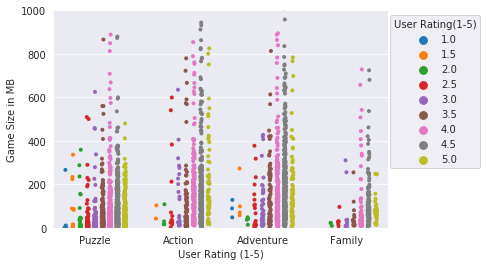

In [6]:
vis1= sns.stripplot(y='Size2' , x='Genre', data=gamestatsfg,\
                hue='User_Rating',dodge=True, size=4)

plt.legend(title='User Rating(1-5)',bbox_to_anchor=(1.29, 1))

vis1.set(ylim=(0, 1000))
vis1.set(xlabel='User Rating (1-5)',ylabel='Game Size in MB')
plt.ioff()

We can easily say that more than half of the games from these 4 genre gets a score of 4 and above, in which the majority focuses on size 400MB and below. With the exception of Action which still gets good rating up to 600MB, and Adventure game up to 800MB. Family (and education) genre has the least number of games in the store, and a 200MB size is sufficient to get score of 4.0 and above.

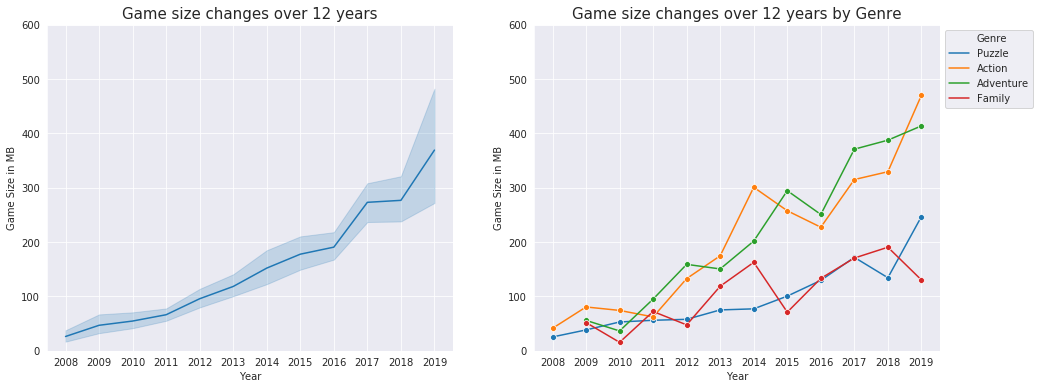

In [7]:
gamestatsfg['Year'] = gamestatsfg['Release_Date']
gamestatsfg['Year']=gamestatsfg['Year'].astype(str)
#extract year ony
for i in (list(gamestatsfg.index.values)):
    gamestatsfg['Year'][i]=gamestatsfg['Year'][i][:4]
    
g, axes = plt.subplots (1,2, figsize=(16,6))

vis1 = sns.lineplot(x=gamestatsfg.Year, y=gamestatsfg.Size2, data=gamestatsfg, ax=axes[0])
vis1.set(ylim=(0, 600))
vis2 = sns.lineplot(x=gamestatsfg.Year, y=gamestatsfg.Size2, hue=gamestatsfg.Genre, err_style=None, marker='o',ax=axes[1])
vis2.set(ylim=(0, 600))
plt.legend(bbox_to_anchor=(1, 1))

axes[0].set_title('Game size changes over 12 years',fontsize=15)
axes[1].set_title('Game size changes over 12 years by Genre',fontsize=15)

vis1.set(xlabel='Year',ylabel='Game Size in MB')
vis2.set(xlabel='Year',ylabel='Game Size in MB')

plt.ioff()

From the left graph we can see a almost Linear (rougly 30MB per year) increase of game size. We can also notice that the error margin has increased constantly over the years, this means the size of game has a bigger range. We can deduce that smaller size games are still relatable but at the same time developers challenged the market with bigger size games (as big as 3.7GB per game)

The right graph shows the growth of game size per game Genre. It is noted that the Game Size fluctuates from year to year, but shows an overall trend of increasing, especially Action Genre which shows a constant growth in the last 5 years

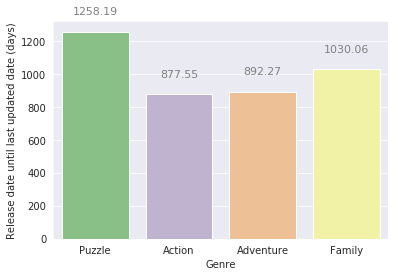

In [8]:
#Convert time delta to int values
for i in (list(gamestatsfg.index.values)):
    gamestatsfg.Update_Gap[i]=gamestatsf.Update_Gap[i].days

x=['Puzzle','Action','Adventure','Family']
y = [gamestatsfg.Update_Gap[(gamestatsfg['Genre']=='Puzzle')].mean(),\
     gamestatsfg.Update_Gap[(gamestatsfg['Genre']=='Action')].mean(),\
     gamestatsfg.Update_Gap[(gamestatsfg['Genre']=='Adventure')].mean(),\
     gamestatsfg.Update_Gap[(gamestatsfg['Genre']=='Family')].mean()]

vis1= sns.barplot(x,y,palette='Accent')
vis1.set(xlabel='Genre',ylabel='Release date until last updated date (days)')



for p in vis1.patches:
             vis1.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')

This chart provides us the insight that on average, Action and Adventure games has more recent updates compared to Puzzle and Family games. We can deduce the need for new content are required for Action and Adventure games is more than Puzzle and Family genre.

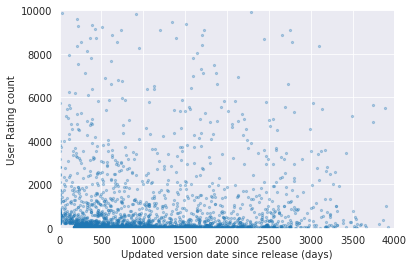

In [9]:
plt.scatter(gamestatsfg.Update_Gap, gamestatsfg.User_Rating_Count, alpha=0.3, s=5) 

plt.xlim(0, 4000)
plt.ylim(0, 10000)

plt.xlabel('Updated version date since release (days)')
plt.ylabel('User Rating count')
plt.show()

We do not have the data of total downloads or total users for each game, but we can assume more user rating count = more downloads. From the graph above, we are able to say there are more User Rating count (hence number of downloads) if the developer provides a more recent update.

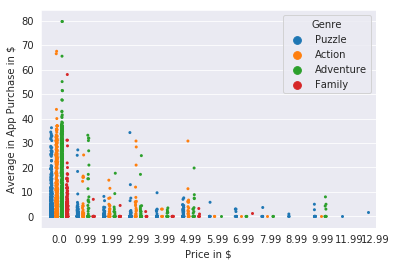

In [10]:
gamestatsfg2=gamestatsfg.copy()
import statistics
gamestatsfg2['In_App_Purchase'] = gamestatsfg2['In_App_Purchase'].str.replace(',', '') 
gamestatsfg2.In_App_Purchase=gamestatsfg2.In_App_Purchase.fillna(0)

for i in (list(gamestatsfg2.index.values)):
    if gamestatsfg2.In_App_Purchase[i] ==0:
        gamestatsfg2['In_App_Purchase'][i]=0.01
    elif gamestatsfg2.In_App_Purchase[i] !=0:
        A=str.split(gamestatsfg2.In_App_Purchase[i])
        A=[float(i) for i in A]
        gamestatsfg2['In_App_Purchase'][i]=statistics.mean(A)
vis1= sns.stripplot(y=gamestatsfg2.In_App_Purchase , x=gamestatsfg2.Price, data=gamestatsfg2, hue=gamestatsfg2.Genre, dodge=True, size=3)

vis1.set(xlabel='Price in $',ylabel='Average in App Purchase in $')
vis1.set(xlim=(-0.7, 12))
plt.ioff()

The pricier the game gets, the lower the In-App Purchase items are. This is expected as low price and free games needs to sustain with some form of income.

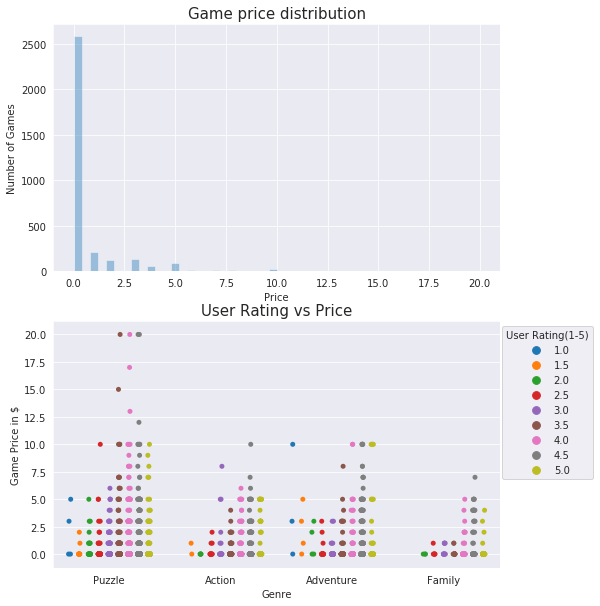

In [11]:
h, axes = plt.subplots (2,1, figsize=(8,10))

vis1 = sns.distplot(gamestatsfg.Price,kde=None,ax=axes[0])
vis2 = sns.stripplot(y=gamestatsfg.Price, x=gamestatsfg.Genre, data=gamestatsfg,ax=axes[1],hue=gamestatsfg.User_Rating, dodge=1)

vis1.set(xlabel='Price',ylabel='Number of Games')
vis2.set(xlabel='Genre',ylabel='Game Price in $')

axes[0].set_title('Game price distribution',fontsize=15)
axes[1].set_title('User Rating vs Price',fontsize=15)
plt.legend(title='User Rating(1-5)',bbox_to_anchor=(1.22, 1))

plt.ioff()

The trend of user rating with respect to price becomes better as the game becomes pricier.


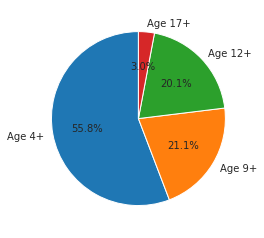

In [12]:
NAR = [gamestatsfg2.Age_Rating[(gamestatsfg2['Age_Rating']=='4+')].count(),gamestatsfg2.Age_Rating[(gamestatsfg2['Age_Rating']=='9+')].count(),\
     gamestatsfg2.Age_Rating[(gamestatsfg2['Age_Rating']=='12+')].count(),gamestatsfg2.Age_Rating[(gamestatsfg2['Age_Rating']=='17+')].count()]
AR = ['Age 4+','Age 9+','Age 12+','Age 17+']

plt.pie(NAR, labels=AR, startangle=90, autopct='%.1f%%')
plt.show()


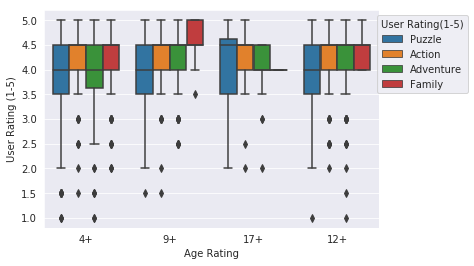

In [13]:
vis1 = sns.boxplot(x=gamestatsfg2.Age_Rating, y=gamestatsfg.User_Rating, data=gamestatsfg, hue=gamestatsfg.Genre, dodge=True)

vis1.set(xlabel='Age Rating',ylabel='User Rating (1-5)')
plt.legend(title='User Rating(1-5)',bbox_to_anchor=(1.28, 1))
plt.ioff()

Inference made:

* For simpler games, focus on size between 100MB to 150MB of contents
* For more complex games, target a content of 500MB and above
* Games above 1GB have good tendancy to land above 3 score and above, provided sufficient resource available to the developer
* Puzzle games are less saturated above 400MB to achieve score 4.0 and above
* Action & Adventure Genre games are less saturated above 600MB to achieve score 4.0 and above
* Family/Educational games has less competition overall
* Almost 90% of the developers focuses on games below 1 Dollar and places In-App Purchase as their strategy for income
* On average, the trend shows that the average game size increase of 30MB per/year but small size games are still relatable in the store.
* Puzzle and Family games requires less game updates on average.
* Paid Games tend to have better reviews espeicially those above 9 Dollar scores 4.0 User Rating
* Consumers enjoy more matured content i.e games targetted for 17+ age and above

Future Work:
Prediction of effect of game size/genre/age rating to User Rating score.

An overall similar visualization is created via Tableau Public for verification purposes.
feel free to access below link for the Tableau Dashboard
https://public.tableau.com/profile/hoihk?fbclid=IwAR0F4YRrr_ziOd63GU7dfRYBrKJXRX0MfgSA2WlGVSzzTC1sLXUD9M6CMSg#!/vizhome/Mobile_Game_Analysis/Dashboard1